# Gradient Boosting Desicion Tree

En las clases anteriores, observamos cómo las mejoras en los algoritmos y las optimizaciones pueden generar avances significativos en la ganancia. Ya hemos logrado un progreso considerable con los modelos de Random Forest. Hoy, daremos un paso aún más grande al explorar los modelos que actualmente están obteniendo los mejores resultados en este tipo de dominios.

Antes que nada, carguemos el entorno de trabajo


In [1]:
%pip install optuna==3.6.1
%pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 8.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

import lightgbm as lgb

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice, plot_contour

from time import time

import pickle

In [3]:
from google.colab import drive

# Montar el drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
base_path = '/content/drive/MyDrive/DMEyF/'
dataset_path = base_path + 'data/'
modelos_path = base_path + 'modelos/'
db_path = base_path + 'db/'
dataset_file = 'competencia_01_fe_20251006.csv'

ganancia_acierto = 780000
costo_estimulo = 20000

mes_train = [202101, 202102, 202103]
#mes_train = 202102

mes_test = 202104

# agregue sus semillas
semillas = [17,19,23,29,31, 47, 83, 77]

data = pd.read_csv(dataset_path + dataset_file)

In [5]:
data['clase_peso'] = 1.0

data.loc[data['clase_ternaria'] == 'baja+2', 'clase_peso'] = 1.00002
data.loc[data['clase_ternaria'] == 'baja+1', 'clase_peso'] = 1.00001

In [6]:
data['clase_binaria1'] = 0
data['clase_binaria2'] = 0
data['clase_binaria1'] = np.where(data['clase_ternaria'] == 'baja+2', 1, 0)
data['clase_binaria2'] = np.where(data['clase_ternaria'] == 'continua', 0, 1)

In [7]:
train_data = data[data['foto_mes'].isin(mes_train)]
#train_data = data[data['foto_mes'] == mes_train]
test_data = data[data['foto_mes'] == mes_test]

X_train = train_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_train_binaria1 = train_data['clase_binaria1']
y_train_binaria2 = train_data['clase_binaria2']
w_train = train_data['clase_peso']

X_test = test_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_test_binaria1 = test_data['clase_binaria1']
y_test_class = test_data['clase_ternaria']
w_test = test_data['clase_peso']

In [8]:
def lgb_gan_eval(y_pred, data):
    weight = data.get_weight()
    ganancia = np.where(weight == 1.00002, ganancia_acierto, 0) - np.where(weight < 1.00002, costo_estimulo, 0)
    ganancia = ganancia[np.argsort(y_pred)[::-1]]
    ganancia = np.cumsum(ganancia)

    return 'gan_eval', np.max(ganancia) , True

# Parámetros del modelos.
params = {
    'objective': 'binary',
    'metric': 'gan_eval',
    'boosting_type': 'gbdt',
    'max_bin': 31,
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 0.3,
    'bagging_fraction': 0.7,
    'verbose': 0
}

In [9]:
def objective(trial):
    # --- Hiperparámetros a optimizar ---
    num_leaves = trial.suggest_int('num_leaves', 8, 100)
    learning_rate = trial.suggest_float('learning_rate', 0.005, 0.3)
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 3, 30)
    feature_fraction = trial.suggest_float('feature_fraction', 0.1, 1.0)
    bagging_fraction = trial.suggest_float('bagging_fraction', 0.1, 1.0)
    bagging_freq = trial.suggest_int('bagging_freq', 1, 7)
    lambda_l1 = trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True)
    lambda_l2 = trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True)
    min_gain_to_split = trial.suggest_float('min_gain_to_split', 0.0, 5.0)
    max_depth = trial.suggest_int('max_depth', 3, 20)

    # --- Configuración del modelo LightGBM ---
    params = {
        'objective': 'binary',
        'metric': 'custom',
        'boosting_type': 'gbdt',
        'first_metric_only': True,
        'boost_from_average': True,
        'feature_pre_filter': False,
        'max_bin': 255,  # importante para GPU
        'num_leaves': num_leaves,
        'learning_rate': learning_rate,
        'min_data_in_leaf': min_data_in_leaf,
        'feature_fraction': feature_fraction,
        'bagging_fraction': bagging_fraction,
        'bagging_freq': bagging_freq,
        'lambda_l1': lambda_l1,
        'lambda_l2': lambda_l2,
        'min_gain_to_split': min_gain_to_split,
        'max_depth': max_depth,
        'seed': semillas[0],
        'verbose': -1,

        # 🚀 Activar GPU
        'device': 'gpu',
        'gpu_platform_id': 0,
        'gpu_device_id': 0,
    }

    # --- Dataset de entrenamiento ---
    train_data = lgb.Dataset(
        X_train,
        label=y_train_binaria2,
        weight=w_train
    )

    early_stopping_rounds = int(50 + 5 / learning_rate)

    # --- Cross-validation con fallback a CPU ---
    try:
        cv_results = lgb.cv(
            params,
            train_data,
            num_boost_round=1600,
            # early_stopping_rounds=early_stopping_rounds,
            feval=lgb_gan_eval,
            stratified=True,
            nfold=5,
            seed=semillas[0]
        )
    except Exception as e:
        print("⚠️ Error al ejecutar LightGBM con GPU, usando CPU como fallback.")
        print("Detalle:", e)
        params['device'] = 'cpu'
        cv_results = lgb.cv(
            params,
            train_data,
            num_boost_round=1600,
            feval=lgb_gan_eval,
            stratified=True,
            nfold=5,
            seed=semillas[0]
        )

    # --- Métrica de ganancia y mejor iteración ---
    max_gan = max(cv_results['valid gan_eval-mean'])
    best_iter = cv_results['valid gan_eval-mean'].index(max_gan) + 1
    trial.set_user_attr("best_iter", best_iter)

    print(f"✅ Trial {trial.number}: mejor ganancia = {max_gan:.2f}, mejor iteración = {best_iter}")

    return max_gan * 5


storage_name = "sqlite:///" + db_path + "optimization_lgbm.db"
study_name = "exp_301_lgbm_20251011"

study = optuna.create_study(
direction="maximize",
study_name=study_name,
storage=storage_name,
load_if_exists=True,
)


[I 2025-10-16 14:02:33,917] Using an existing study with name 'exp_301_lgbm_20251011' instead of creating a new one.


In [ ]:
study.optimize(objective, n_trials=40) # subir (100 originalmente)

[I 2025-10-11 04:13:13,809] Trial 6 finished with value: 780020000.0 and parameters: {'num_leaves': 66, 'learning_rate': 0.09051841625251619, 'min_data_in_leaf': 13, 'feature_fraction': 0.5575269254809823, 'bagging_fraction': 0.4082455109434324, 'bagging_freq': 2, 'lambda_l1': 9.947428192726367, 'lambda_l2': 0.028236234126021047, 'min_gain_to_split': 4.7799519852456305, 'max_depth': 8}. Best is trial 3 with value: 885280000.0.


✅ Trial 6: mejor ganancia = 156004000.00, mejor iteración = 117


[I 2025-10-11 04:15:17,630] Trial 7 finished with value: 809120000.0 and parameters: {'num_leaves': 57, 'learning_rate': 0.07521821582657874, 'min_data_in_leaf': 8, 'feature_fraction': 0.9578125970359092, 'bagging_fraction': 0.9367992574219149, 'bagging_freq': 7, 'lambda_l1': 2.214705859381408e-06, 'lambda_l2': 2.5726810852463035e-05, 'min_gain_to_split': 2.044512742681005, 'max_depth': 11}. Best is trial 3 with value: 885280000.0.


✅ Trial 7: mejor ganancia = 161824000.00, mejor iteración = 136


[I 2025-10-11 04:18:06,875] Trial 8 finished with value: 767740000.0 and parameters: {'num_leaves': 86, 'learning_rate': 0.19957781491625284, 'min_data_in_leaf': 10, 'feature_fraction': 0.7202548318438523, 'bagging_fraction': 0.38547898453045204, 'bagging_freq': 1, 'lambda_l1': 0.14164085048467956, 'lambda_l2': 7.1696503558669, 'min_gain_to_split': 1.501784503136958, 'max_depth': 16}. Best is trial 3 with value: 885280000.0.


✅ Trial 8: mejor ganancia = 153548000.00, mejor iteración = 684


[I 2025-10-11 04:19:56,248] Trial 9 finished with value: 521380000.0 and parameters: {'num_leaves': 49, 'learning_rate': 0.2562700139545478, 'min_data_in_leaf': 22, 'feature_fraction': 0.8822439953321529, 'bagging_fraction': 0.11339061803073149, 'bagging_freq': 5, 'lambda_l1': 6.201932153293908e-08, 'lambda_l2': 0.0004969923790883227, 'min_gain_to_split': 1.7911864732787375, 'max_depth': 10}. Best is trial 3 with value: 885280000.0.


✅ Trial 9: mejor ganancia = 104276000.00, mejor iteración = 1


[I 2025-10-11 04:23:06,485] Trial 10 finished with value: 844040000.0 and parameters: {'num_leaves': 32, 'learning_rate': 0.027029274918894283, 'min_data_in_leaf': 24, 'feature_fraction': 0.4686118261462009, 'bagging_fraction': 0.8187897835642484, 'bagging_freq': 7, 'lambda_l1': 1.1050082576383429e-06, 'lambda_l2': 0.00833017292593737, 'min_gain_to_split': 3.7244276281924336, 'max_depth': 18}. Best is trial 3 with value: 885280000.0.


✅ Trial 10: mejor ganancia = 168808000.00, mejor iteración = 488


[I 2025-10-11 04:28:15,505] Trial 11 finished with value: 822280000.0 and parameters: {'num_leaves': 64, 'learning_rate': 0.021097522449578375, 'min_data_in_leaf': 11, 'feature_fraction': 0.8809796053103872, 'bagging_fraction': 0.13368740983196215, 'bagging_freq': 7, 'lambda_l1': 1.2477150368274108e-08, 'lambda_l2': 0.0020099750400486976, 'min_gain_to_split': 1.0959194940465493, 'max_depth': 12}. Best is trial 3 with value: 885280000.0.


✅ Trial 11: mejor ganancia = 164456000.00, mejor iteración = 1549


[I 2025-10-11 04:30:07,675] Trial 12 finished with value: 824100000.0 and parameters: {'num_leaves': 96, 'learning_rate': 0.11258799203997938, 'min_data_in_leaf': 18, 'feature_fraction': 0.9733117278409413, 'bagging_fraction': 0.9110321419172421, 'bagging_freq': 2, 'lambda_l1': 2.5344674755527787, 'lambda_l2': 0.8816076053209814, 'min_gain_to_split': 2.595959545400257, 'max_depth': 7}. Best is trial 3 with value: 885280000.0.


✅ Trial 12: mejor ganancia = 164820000.00, mejor iteración = 144


[I 2025-10-11 04:32:56,249] Trial 13 finished with value: 794520000.0 and parameters: {'num_leaves': 10, 'learning_rate': 0.1523715613730614, 'min_data_in_leaf': 30, 'feature_fraction': 0.16105521053629945, 'bagging_fraction': 0.6022022813565031, 'bagging_freq': 5, 'lambda_l1': 0.002779040717810571, 'lambda_l2': 5.333894108820141e-07, 'min_gain_to_split': 0.15609712992167735, 'max_depth': 3}. Best is trial 3 with value: 885280000.0.


✅ Trial 13: mejor ganancia = 158904000.00, mejor iteración = 622


[I 2025-10-11 04:36:36,752] Trial 14 finished with value: 847740000.0 and parameters: {'num_leaves': 33, 'learning_rate': 0.01586290038867233, 'min_data_in_leaf': 28, 'feature_fraction': 0.27347022575566643, 'bagging_fraction': 0.6653030522517147, 'bagging_freq': 4, 'lambda_l1': 5.698663468294275e-07, 'lambda_l2': 0.0218438092567704, 'min_gain_to_split': 3.4654887992565193, 'max_depth': 18}. Best is trial 3 with value: 885280000.0.


✅ Trial 14: mejor ganancia = 169548000.00, mejor iteración = 1590


[I 2025-10-11 04:40:33,226] Trial 15 finished with value: 854980000.0 and parameters: {'num_leaves': 38, 'learning_rate': 0.012211445969496408, 'min_data_in_leaf': 30, 'feature_fraction': 0.22645451168503278, 'bagging_fraction': 0.6187989158678103, 'bagging_freq': 4, 'lambda_l1': 0.0001725814403151333, 'lambda_l2': 0.04258640220267223, 'min_gain_to_split': 3.147360500778619, 'max_depth': 20}. Best is trial 3 with value: 885280000.0.


✅ Trial 15: mejor ganancia = 170996000.00, mejor iteración = 1155


[I 2025-10-11 04:44:22,476] Trial 16 finished with value: 764480000.0 and parameters: {'num_leaves': 43, 'learning_rate': 0.057534010784648176, 'min_data_in_leaf': 3, 'feature_fraction': 0.38882636317465563, 'bagging_fraction': 0.44343536460541844, 'bagging_freq': 4, 'lambda_l1': 0.0005837631008860568, 'lambda_l2': 1.4348534953223476e-08, 'min_gain_to_split': 0.591321477090182, 'max_depth': 5}. Best is trial 3 with value: 885280000.0.


✅ Trial 16: mejor ganancia = 152896000.00, mejor iteración = 128


[I 2025-10-11 04:47:08,886] Trial 17 finished with value: 788060000.0 and parameters: {'num_leaves': 17, 'learning_rate': 0.14415240702090565, 'min_data_in_leaf': 26, 'feature_fraction': 0.1381907229689912, 'bagging_fraction': 0.5212646222131212, 'bagging_freq': 3, 'lambda_l1': 0.02111859601194181, 'lambda_l2': 0.1766993783826754, 'min_gain_to_split': 3.0146042277834404, 'max_depth': 14}. Best is trial 3 with value: 885280000.0.


✅ Trial 17: mejor ganancia = 157612000.00, mejor iteración = 1577


[I 2025-10-11 04:50:15,308] Trial 18 finished with value: 810080000.0 and parameters: {'num_leaves': 37, 'learning_rate': 0.052027847697573515, 'min_data_in_leaf': 22, 'feature_fraction': 0.3134268173172718, 'bagging_fraction': 0.2766808333502707, 'bagging_freq': 5, 'lambda_l1': 7.635412836684516e-05, 'lambda_l2': 5.719502105978763e-05, 'min_gain_to_split': 4.0551442122661205, 'max_depth': 6}. Best is trial 3 with value: 885280000.0.


✅ Trial 18: mejor ganancia = 162016000.00, mejor iteración = 794


[I 2025-10-11 04:52:46,516] Trial 19 finished with value: 768000000.0 and parameters: {'num_leaves': 24, 'learning_rate': 0.20257936257062087, 'min_data_in_leaf': 30, 'feature_fraction': 0.571050388070308, 'bagging_fraction': 0.6988910723064243, 'bagging_freq': 3, 'lambda_l1': 3.207100142756397e-05, 'lambda_l2': 0.08269210084021525, 'min_gain_to_split': 2.610713744240189, 'max_depth': 20}. Best is trial 3 with value: 885280000.0.


✅ Trial 19: mejor ganancia = 153600000.00, mejor iteración = 187


[I 2025-10-11 04:55:46,998] Trial 20 finished with value: 824060000.0 and parameters: {'num_leaves': 56, 'learning_rate': 0.11242922832447694, 'min_data_in_leaf': 25, 'feature_fraction': 0.23209914972545098, 'bagging_fraction': 0.5335098472209834, 'bagging_freq': 2, 'lambda_l1': 0.006633494246188244, 'lambda_l2': 0.0014867571154600354, 'min_gain_to_split': 0.9590789370847204, 'max_depth': 3}. Best is trial 3 with value: 885280000.0.


✅ Trial 20: mejor ganancia = 164812000.00, mejor iteración = 1038


[I 2025-10-11 05:00:44,308] Trial 21 finished with value: 833760000.0 and parameters: {'num_leaves': 44, 'learning_rate': 0.005372991639692272, 'min_data_in_leaf': 27, 'feature_fraction': 0.3976409249256454, 'bagging_fraction': 0.26983177500966976, 'bagging_freq': 6, 'lambda_l1': 0.22813511983882073, 'lambda_l2': 8.456490303179065e-05, 'min_gain_to_split': 0.10233835487406512, 'max_depth': 14}. Best is trial 3 with value: 885280000.0.


✅ Trial 21: mejor ganancia = 166752000.00, mejor iteración = 1596


[I 2025-10-11 05:03:34,588] Trial 22 finished with value: 830780000.0 and parameters: {'num_leaves': 75, 'learning_rate': 0.05456469879474917, 'min_data_in_leaf': 21, 'feature_fraction': 0.10090965037204791, 'bagging_fraction': 0.687503524765696, 'bagging_freq': 3, 'lambda_l1': 6.502868495036031e-08, 'lambda_l2': 5.509592225566418, 'min_gain_to_split': 3.2662211492249025, 'max_depth': 20}. Best is trial 3 with value: 885280000.0.


✅ Trial 22: mejor ganancia = 166156000.00, mejor iteración = 838


[I 2025-10-11 05:07:35,052] Trial 23 finished with value: 644540000.0 and parameters: {'num_leaves': 25, 'learning_rate': 0.2981267804648443, 'min_data_in_leaf': 30, 'feature_fraction': 0.45221065063475974, 'bagging_fraction': 0.7593108725505208, 'bagging_freq': 4, 'lambda_l1': 0.0003451545840754013, 'lambda_l2': 4.527120702160166e-06, 'min_gain_to_split': 4.1166268242257456, 'max_depth': 13}. Best is trial 3 with value: 885280000.0.


✅ Trial 23: mejor ganancia = 128908000.00, mejor iteración = 8


[I 2025-10-11 05:10:49,817] Trial 24 finished with value: 853700000.0 and parameters: {'num_leaves': 33, 'learning_rate': 0.034327929842525876, 'min_data_in_leaf': 27, 'feature_fraction': 0.26963731552842474, 'bagging_fraction': 0.620755900965839, 'bagging_freq': 4, 'lambda_l1': 2.618138357570312e-07, 'lambda_l2': 0.01024164826181424, 'min_gain_to_split': 3.385541627530322, 'max_depth': 17}. Best is trial 3 with value: 885280000.0.


✅ Trial 24: mejor ganancia = 170740000.00, mejor iteración = 1547


[I 2025-10-11 05:14:01,366] Trial 25 finished with value: 851960000.0 and parameters: {'num_leaves': 51, 'learning_rate': 0.04006265822107487, 'min_data_in_leaf': 24, 'feature_fraction': 0.21805039191979167, 'bagging_fraction': 0.5892103862870502, 'bagging_freq': 6, 'lambda_l1': 9.247582242751372e-06, 'lambda_l2': 0.004109098045997777, 'min_gain_to_split': 2.797415951878699, 'max_depth': 18}. Best is trial 3 with value: 885280000.0.


✅ Trial 25: mejor ganancia = 170392000.00, mejor iteración = 591


[I 2025-10-11 05:16:46,663] Trial 26 finished with value: 815480000.0 and parameters: {'num_leaves': 42, 'learning_rate': 0.08789102996960643, 'min_data_in_leaf': 28, 'feature_fraction': 0.3475196783682619, 'bagging_fraction': 0.48757305226021924, 'bagging_freq': 5, 'lambda_l1': 1.2157704541067983e-08, 'lambda_l2': 0.20566424967740324, 'min_gain_to_split': 3.7944077074919274, 'max_depth': 16}. Best is trial 3 with value: 885280000.0.


✅ Trial 26: mejor ganancia = 163096000.00, mejor iteración = 216


[I 2025-10-11 05:20:31,782] Trial 27 finished with value: 821580000.0 and parameters: {'num_leaves': 29, 'learning_rate': 0.005304026359553064, 'min_data_in_leaf': 27, 'feature_fraction': 0.21580700074394688, 'bagging_fraction': 0.34898395295283635, 'bagging_freq': 2, 'lambda_l1': 2.3990881450337746e-07, 'lambda_l2': 0.0003900834710742664, 'min_gain_to_split': 4.410537562081899, 'max_depth': 16}. Best is trial 3 with value: 885280000.0.


✅ Trial 27: mejor ganancia = 164316000.00, mejor iteración = 1534


[I 2025-10-11 05:23:25,274] Trial 28 finished with value: 820940000.0 and parameters: {'num_leaves': 62, 'learning_rate': 0.07269616635357545, 'min_data_in_leaf': 20, 'feature_fraction': 0.45638061003883446, 'bagging_fraction': 0.5984919839401893, 'bagging_freq': 4, 'lambda_l1': 8.50366147932625e-06, 'lambda_l2': 0.03493139812476697, 'min_gain_to_split': 3.260607893200745, 'max_depth': 20}. Best is trial 3 with value: 885280000.0.


✅ Trial 28: mejor ganancia = 164188000.00, mejor iteración = 346


[I 2025-10-11 05:26:56,489] Trial 29 finished with value: 868480000.0 and parameters: {'num_leaves': 16, 'learning_rate': 0.034901477164889144, 'min_data_in_leaf': 24, 'feature_fraction': 0.2965020597879361, 'bagging_fraction': 0.46800718781856515, 'bagging_freq': 6, 'lambda_l1': 1.2343170087941058e-07, 'lambda_l2': 0.6726814317460607, 'min_gain_to_split': 2.1372658259637953, 'max_depth': 17}. Best is trial 3 with value: 885280000.0.


✅ Trial 29: mejor ganancia = 173696000.00, mejor iteración = 1532


[I 2025-10-11 05:29:18,502] Trial 30 finished with value: 814780000.0 and parameters: {'num_leaves': 8, 'learning_rate': 0.11486883365964895, 'min_data_in_leaf': 23, 'feature_fraction': 0.6592613375564559, 'bagging_fraction': 0.3038031047108211, 'bagging_freq': 6, 'lambda_l1': 6.05834122597729e-08, 'lambda_l2': 0.7601146603221764, 'min_gain_to_split': 2.201378374901781, 'max_depth': 19}. Best is trial 3 with value: 885280000.0.


✅ Trial 30: mejor ganancia = 162956000.00, mejor iteración = 1509


[I 2025-10-11 05:32:46,623] Trial 31 finished with value: 821700000.0 and parameters: {'num_leaves': 14, 'learning_rate': 0.18881523315696788, 'min_data_in_leaf': 16, 'feature_fraction': 0.333546750663168, 'bagging_fraction': 0.47384142373965665, 'bagging_freq': 6, 'lambda_l1': 5.269323005313026e-06, 'lambda_l2': 2.210507803613333, 'min_gain_to_split': 1.3945893844945623, 'max_depth': 15}. Best is trial 3 with value: 885280000.0.


✅ Trial 31: mejor ganancia = 164340000.00, mejor iteración = 426


[I 2025-10-11 05:36:25,567] Trial 32 finished with value: 837860000.0 and parameters: {'num_leaves': 20, 'learning_rate': 0.03453371720881148, 'min_data_in_leaf': 17, 'feature_fraction': 0.5068069372550136, 'bagging_fraction': 0.21250150083873764, 'bagging_freq': 1, 'lambda_l1': 1.1046216914769599e-07, 'lambda_l2': 0.160783422391911, 'min_gain_to_split': 0.585003853435712, 'max_depth': 5}. Best is trial 3 with value: 885280000.0.


✅ Trial 32: mejor ganancia = 167572000.00, mejor iteración = 1567


[I 2025-10-11 05:39:33,729] Trial 33 finished with value: 807620000.0 and parameters: {'num_leaves': 82, 'learning_rate': 0.13126050601708572, 'min_data_in_leaf': 25, 'feature_fraction': 0.4043856203076118, 'bagging_fraction': 0.7581400662049294, 'bagging_freq': 1, 'lambda_l1': 1.9579643147153008e-06, 'lambda_l2': 0.06514366183559643, 'min_gain_to_split': 2.3232848158570434, 'max_depth': 9}. Best is trial 3 with value: 885280000.0.


✅ Trial 33: mejor ganancia = 161524000.00, mejor iteración = 1165


[I 2025-10-11 05:42:50,846] Trial 34 finished with value: 848500000.0 and parameters: {'num_leaves': 37, 'learning_rate': 0.044149024310233875, 'min_data_in_leaf': 28, 'feature_fraction': 0.28801520981610756, 'bagging_fraction': 0.6215531658306043, 'bagging_freq': 4, 'lambda_l1': 4.2369901154114196e-07, 'lambda_l2': 0.010104089747448189, 'min_gain_to_split': 2.8453444367454424, 'max_depth': 17}. Best is trial 3 with value: 885280000.0.


✅ Trial 34: mejor ganancia = 169700000.00, mejor iteración = 445


[I 2025-10-11 05:45:54,121] Trial 35 finished with value: 849080000.0 and parameters: {'num_leaves': 24, 'learning_rate': 0.06406512860269634, 'min_data_in_leaf': 29, 'feature_fraction': 0.1932006311773436, 'bagging_fraction': 0.552780098153657, 'bagging_freq': 5, 'lambda_l1': 2.5534308413615778e-08, 'lambda_l2': 0.44426770437687363, 'min_gain_to_split': 3.191907600656674, 'max_depth': 19}. Best is trial 3 with value: 885280000.0.


✅ Trial 35: mejor ganancia = 169816000.00, mejor iteración = 1301


[I 2025-10-11 05:48:31,601] Trial 36 finished with value: 790420000.0 and parameters: {'num_leaves': 49, 'learning_rate': 0.09200438966216096, 'min_data_in_leaf': 26, 'feature_fraction': 0.2816417972233069, 'bagging_fraction': 0.45066275694982033, 'bagging_freq': 3, 'lambda_l1': 2.2677159994229418e-07, 'lambda_l2': 0.011763051073973995, 'min_gain_to_split': 4.960090635193753, 'max_depth': 13}. Best is trial 3 with value: 885280000.0.


✅ Trial 36: mejor ganancia = 158084000.00, mejor iteración = 739


[I 2025-10-11 05:52:21,286] Trial 37 finished with value: 879100000.0 and parameters: {'num_leaves': 72, 'learning_rate': 0.02639403580916544, 'min_data_in_leaf': 27, 'feature_fraction': 0.3597200218606935, 'bagging_fraction': 0.8297346836818289, 'bagging_freq': 4, 'lambda_l1': 3.958506744114129e-05, 'lambda_l2': 0.0010706837119926623, 'min_gain_to_split': 1.9144504118398324, 'max_depth': 17}. Best is trial 3 with value: 885280000.0.


✅ Trial 37: mejor ganancia = 175820000.00, mejor iteración = 832


[I 2025-10-11 05:55:52,411] Trial 38 finished with value: 871960000.0 and parameters: {'num_leaves': 72, 'learning_rate': 0.02117621620669941, 'min_data_in_leaf': 24, 'feature_fraction': 0.5864536903535879, 'bagging_fraction': 0.97297340591007, 'bagging_freq': 2, 'lambda_l1': 6.507093543249984e-05, 'lambda_l2': 0.001246690216893892, 'min_gain_to_split': 1.829121089929155, 'max_depth': 19}. Best is trial 3 with value: 885280000.0.


✅ Trial 38: mejor ganancia = 174392000.00, mejor iteración = 578


[I 2025-10-11 05:58:18,444] Trial 39 finished with value: 827320000.0 and parameters: {'num_leaves': 72, 'learning_rate': 0.08789186630463519, 'min_data_in_leaf': 20, 'feature_fraction': 0.6150094698673898, 'bagging_fraction': 0.9556972558772927, 'bagging_freq': 2, 'lambda_l1': 2.2839906706738488e-05, 'lambda_l2': 0.001185032652355327, 'min_gain_to_split': 1.8382299137290334, 'max_depth': 11}. Best is trial 3 with value: 885280000.0.


✅ Trial 39: mejor ganancia = 165464000.00, mejor iteración = 127


[I 2025-10-11 06:01:16,615] Trial 40 finished with value: 867920000.0 and parameters: {'num_leaves': 77, 'learning_rate': 0.07268233693102996, 'min_data_in_leaf': 23, 'feature_fraction': 0.5352056347798975, 'bagging_fraction': 0.9994381069943388, 'bagging_freq': 1, 'lambda_l1': 0.0012878729954103733, 'lambda_l2': 0.00013405331705908585, 'min_gain_to_split': 1.5555233139126405, 'max_depth': 9}. Best is trial 3 with value: 885280000.0.


✅ Trial 40: mejor ganancia = 173584000.00, mejor iteración = 271


[I 2025-10-11 06:04:18,543] Trial 41 finished with value: 878540000.0 and parameters: {'num_leaves': 91, 'learning_rate': 0.023754491142086418, 'min_data_in_leaf': 14, 'feature_fraction': 0.7387189370974714, 'bagging_fraction': 0.8550177970203591, 'bagging_freq': 2, 'lambda_l1': 3.4938320720141444e-06, 'lambda_l2': 1.6722348294711028e-05, 'min_gain_to_split': 1.9449210687455183, 'max_depth': 17}. Best is trial 3 with value: 885280000.0.


✅ Trial 41: mejor ganancia = 175708000.00, mejor iteración = 661
⚠️ Error al ejecutar LightGBM con GPU, usando CPU como fallback.
Detalle: Check failed: (best_split_info.left_count) > (0) at /tmp/lightgbm/LightGBM/lightgbm-python/src/treelearner/serial_tree_learner.cpp, line 852 .



[I 2025-10-11 06:12:35,045] Trial 42 finished with value: 703160000.0 and parameters: {'num_leaves': 88, 'learning_rate': 0.17742982080470016, 'min_data_in_leaf': 12, 'feature_fraction': 0.7764216077736333, 'bagging_fraction': 0.8644543017030994, 'bagging_freq': 2, 'lambda_l1': 9.056400986889225e-05, 'lambda_l2': 1.166230395867887e-05, 'min_gain_to_split': 1.1566552340031682, 'max_depth': 15}. Best is trial 3 with value: 885280000.0.


✅ Trial 42: mejor ganancia = 140632000.00, mejor iteración = 5


[I 2025-10-11 06:15:37,120] Trial 43 finished with value: 886880000.0 and parameters: {'num_leaves': 97, 'learning_rate': 0.02454138072858449, 'min_data_in_leaf': 15, 'feature_fraction': 0.7169039372749014, 'bagging_fraction': 0.8422681435986042, 'bagging_freq': 3, 'lambda_l1': 1.8472509093197397e-06, 'lambda_l2': 6.309406949878185e-07, 'min_gain_to_split': 1.8542985333491084, 'max_depth': 10}. Best is trial 43 with value: 886880000.0.


✅ Trial 43: mejor ganancia = 177376000.00, mejor iteración = 1039


[I 2025-10-11 06:18:37,971] Trial 44 finished with value: 885720000.0 and parameters: {'num_leaves': 98, 'learning_rate': 0.025069670409947602, 'min_data_in_leaf': 14, 'feature_fraction': 0.7040900722641266, 'bagging_fraction': 0.8353060020310342, 'bagging_freq': 3, 'lambda_l1': 2.9278109647877793e-06, 'lambda_l2': 2.722890491725677e-07, 'min_gain_to_split': 1.871142274701454, 'max_depth': 10}. Best is trial 43 with value: 886880000.0.


✅ Trial 44: mejor ganancia = 177144000.00, mejor iteración = 700


[I 2025-10-11 06:21:48,800] Trial 45 finished with value: 882920000.0 and parameters: {'num_leaves': 98, 'learning_rate': 0.024805756028323966, 'min_data_in_leaf': 15, 'feature_fraction': 0.7229966979758169, 'bagging_fraction': 0.8612882289044682, 'bagging_freq': 3, 'lambda_l1': 1.1345014634699303e-06, 'lambda_l2': 2.5733086087413116e-07, 'min_gain_to_split': 1.541386770512383, 'max_depth': 10}. Best is trial 43 with value: 886880000.0.


✅ Trial 45: mejor ganancia = 176584000.00, mejor iteración = 622


In [ ]:
study.optimize(objective, n_trials=20) # subir (100 originalmente)

[I 2025-10-11 06:25:33,548] Trial 46 finished with value: 681220000.0 and parameters: {'num_leaves': 95, 'learning_rate': 0.2353609795688737, 'min_data_in_leaf': 15, 'feature_fraction': 0.6825908191774251, 'bagging_fraction': 0.7927354682034016, 'bagging_freq': 3, 'lambda_l1': 9.635490956616116e-07, 'lambda_l2': 1.2678289309668215e-07, 'min_gain_to_split': 1.5551998448338042, 'max_depth': 10}. Best is trial 43 with value: 886880000.0.


✅ Trial 46: mejor ganancia = 136244000.00, mejor iteración = 1


[I 2025-10-11 06:28:36,405] Trial 47 finished with value: 892960000.0 and parameters: {'num_leaves': 98, 'learning_rate': 0.04747366667059999, 'min_data_in_leaf': 10, 'feature_fraction': 0.8515960545426435, 'bagging_fraction': 0.8875058215377718, 'bagging_freq': 3, 'lambda_l1': 1.4645187765002807e-05, 'lambda_l2': 1.2173892103248195e-07, 'min_gain_to_split': 0.829020714721596, 'max_depth': 8}. Best is trial 47 with value: 892960000.0.


✅ Trial 47: mejor ganancia = 178592000.00, mejor iteración = 560


[I 2025-10-11 06:31:49,842] Trial 48 finished with value: 882920000.0 and parameters: {'num_leaves': 100, 'learning_rate': 0.04831312841823071, 'min_data_in_leaf': 8, 'feature_fraction': 0.8689631077742632, 'bagging_fraction': 0.9133745855388326, 'bagging_freq': 3, 'lambda_l1': 1.0797491703551009e-06, 'lambda_l2': 1.2408030965047508e-07, 'min_gain_to_split': 0.6588686870076252, 'max_depth': 8}. Best is trial 47 with value: 892960000.0.


✅ Trial 48: mejor ganancia = 176584000.00, mejor iteración = 724


[I 2025-10-11 06:35:10,339] Trial 49 finished with value: 885060000.0 and parameters: {'num_leaves': 100, 'learning_rate': 0.06606547045787951, 'min_data_in_leaf': 8, 'feature_fraction': 0.7839864524062261, 'bagging_fraction': 0.8814081870598665, 'bagging_freq': 3, 'lambda_l1': 1.266405751769357e-05, 'lambda_l2': 8.318725863982701e-07, 'min_gain_to_split': 0.3908450919087779, 'max_depth': 8}. Best is trial 47 with value: 892960000.0.


✅ Trial 49: mejor ganancia = 177012000.00, mejor iteración = 701


[I 2025-10-11 06:38:51,752] Trial 50 finished with value: 881320000.0 and parameters: {'num_leaves': 93, 'learning_rate': 0.06167932390500422, 'min_data_in_leaf': 8, 'feature_fraction': 0.8429551817089457, 'bagging_fraction': 0.7525252426211214, 'bagging_freq': 3, 'lambda_l1': 1.3885136609669976e-05, 'lambda_l2': 1.988875053078757e-06, 'min_gain_to_split': 0.4636985335380335, 'max_depth': 7}. Best is trial 47 with value: 892960000.0.


✅ Trial 50: mejor ganancia = 176264000.00, mejor iteración = 1197
⚠️ Error al ejecutar LightGBM con GPU, usando CPU como fallback.
Detalle: Check failed: (best_split_info.left_count) > (0) at /tmp/lightgbm/LightGBM/lightgbm-python/src/treelearner/serial_tree_learner.cpp, line 852 .



[I 2025-10-11 06:47:53,375] Trial 51 finished with value: 828320000.0 and parameters: {'num_leaves': 84, 'learning_rate': 0.10104349100755082, 'min_data_in_leaf': 5, 'feature_fraction': 0.9256411560094239, 'bagging_fraction': 0.897488542867952, 'bagging_freq': 3, 'lambda_l1': 3.3630707175521914e-06, 'lambda_l2': 2.069414158690887e-08, 'min_gain_to_split': 0.31283833870661426, 'max_depth': 8}. Best is trial 47 with value: 892960000.0.


✅ Trial 51: mejor ganancia = 165664000.00, mejor iteración = 414


[I 2025-10-11 06:50:53,949] Trial 52 finished with value: 873520000.0 and parameters: {'num_leaves': 80, 'learning_rate': 0.07508857289318917, 'min_data_in_leaf': 10, 'feature_fraction': 0.7889997707699644, 'bagging_fraction': 0.798358200212754, 'bagging_freq': 2, 'lambda_l1': 2.9637729338369688e-08, 'lambda_l2': 3.5997034561223026e-08, 'min_gain_to_split': 0.8614604477363068, 'max_depth': 7}. Best is trial 47 with value: 892960000.0.


✅ Trial 52: mejor ganancia = 174704000.00, mejor iteración = 404


[I 2025-10-11 06:54:03,759] Trial 53 finished with value: 876960000.0 and parameters: {'num_leaves': 90, 'learning_rate': 0.04744164281945458, 'min_data_in_leaf': 10, 'feature_fraction': 0.9276051948103381, 'bagging_fraction': 0.717224277106461, 'bagging_freq': 3, 'lambda_l1': 0.0002103534351078919, 'lambda_l2': 2.516418900335881e-06, 'min_gain_to_split': 1.2677705054132231, 'max_depth': 6}. Best is trial 47 with value: 892960000.0.


✅ Trial 53: mejor ganancia = 175392000.00, mejor iteración = 911


[I 2025-10-11 06:58:46,458] Trial 54 finished with value: 895140000.0 and parameters: {'num_leaves': 98, 'learning_rate': 0.020258317099892842, 'min_data_in_leaf': 12, 'feature_fraction': 0.6982100676273879, 'bagging_fraction': 0.8655572819307843, 'bagging_freq': 3, 'lambda_l1': 6.48251090946355e-07, 'lambda_l2': 5.193789724444845e-07, 'min_gain_to_split': 0.8805380180433298, 'max_depth': 10}. Best is trial 54 with value: 895140000.0.


✅ Trial 54: mejor ganancia = 179028000.00, mejor iteración = 1141


[I 2025-10-11 07:04:00,236] Trial 55 finished with value: 889760000.0 and parameters: {'num_leaves': 100, 'learning_rate': 0.01591801560421857, 'min_data_in_leaf': 13, 'feature_fraction': 0.6841811188916124, 'bagging_fraction': 0.9236825588640427, 'bagging_freq': 3, 'lambda_l1': 7.057273982524802e-07, 'lambda_l2': 5.532046098354979e-07, 'min_gain_to_split': 0.8375544589892838, 'max_depth': 9}. Best is trial 54 with value: 895140000.0.


✅ Trial 55: mejor ganancia = 177952000.00, mejor iteración = 1281


[I 2025-10-11 07:07:18,237] Trial 56 finished with value: 880500000.0 and parameters: {'num_leaves': 95, 'learning_rate': 0.034867033914117676, 'min_data_in_leaf': 13, 'feature_fraction': 0.6755958649277675, 'bagging_fraction': 0.912523818287504, 'bagging_freq': 3, 'lambda_l1': 5.724369667077449e-07, 'lambda_l2': 3.8304172808179256e-07, 'min_gain_to_split': 0.934805876509208, 'max_depth': 10}. Best is trial 54 with value: 895140000.0.


✅ Trial 56: mejor ganancia = 176100000.00, mejor iteración = 621


[I 2025-10-11 07:14:20,913] Trial 57 finished with value: 912440000.0 and parameters: {'num_leaves': 87, 'learning_rate': 0.020463445684215154, 'min_data_in_leaf': 12, 'feature_fraction': 0.6531536296641696, 'bagging_fraction': 0.9329765028378016, 'bagging_freq': 2, 'lambda_l1': 1.9597087324210312e-06, 'lambda_l2': 9.166920661671571e-08, 'min_gain_to_split': 0.08010762814157912, 'max_depth': 12}. Best is trial 57 with value: 912440000.0.


✅ Trial 57: mejor ganancia = 182488000.00, mejor iteración = 1568


[I 2025-10-11 07:21:37,612] Trial 58 finished with value: 906440000.0 and parameters: {'num_leaves': 87, 'learning_rate': 0.011520415241119056, 'min_data_in_leaf': 12, 'feature_fraction': 0.6527266220038186, 'bagging_fraction': 0.9411172682695189, 'bagging_freq': 2, 'lambda_l1': 2.980868388046977e-06, 'lambda_l2': 6.979354137294941e-08, 'min_gain_to_split': 0.0090702590337024, 'max_depth': 12}. Best is trial 57 with value: 912440000.0.


✅ Trial 58: mejor ganancia = 181288000.00, mejor iteración = 1552


[I 2025-10-11 07:28:45,510] Trial 59 finished with value: 895280000.0 and parameters: {'num_leaves': 86, 'learning_rate': 0.01230104077935058, 'min_data_in_leaf': 12, 'feature_fraction': 0.6351800839135112, 'bagging_fraction': 0.9410106681884254, 'bagging_freq': 2, 'lambda_l1': 4.397561404363064e-07, 'lambda_l2': 7.957247793691412e-08, 'min_gain_to_split': 0.023339025708801087, 'max_depth': 11}. Best is trial 57 with value: 912440000.0.


✅ Trial 59: mejor ganancia = 179056000.00, mejor iteración = 1588


[I 2025-10-11 07:36:00,367] Trial 60 finished with value: 894140000.0 and parameters: {'num_leaves': 86, 'learning_rate': 0.012920995853901558, 'min_data_in_leaf': 12, 'feature_fraction': 0.6042197181626112, 'bagging_fraction': 0.9402021749687783, 'bagging_freq': 1, 'lambda_l1': 5.394481209832294e-07, 'lambda_l2': 7.218757478245655e-08, 'min_gain_to_split': 0.11120746443550476, 'max_depth': 12}. Best is trial 57 with value: 912440000.0.


✅ Trial 60: mejor ganancia = 178828000.00, mejor iteración = 1511


[I 2025-10-11 07:43:28,603] Trial 61 finished with value: 875840000.0 and parameters: {'num_leaves': 86, 'learning_rate': 0.005677576197629778, 'min_data_in_leaf': 11, 'feature_fraction': 0.6154397444667556, 'bagging_fraction': 0.990460475267806, 'bagging_freq': 1, 'lambda_l1': 6.263646910549932e-06, 'lambda_l2': 6.267063700797235e-08, 'min_gain_to_split': 0.041140644571768775, 'max_depth': 12}. Best is trial 57 with value: 912440000.0.


✅ Trial 61: mejor ganancia = 175168000.00, mejor iteración = 1554


[I 2025-10-11 07:49:34,416] Trial 62 finished with value: 895080000.0 and parameters: {'num_leaves': 66, 'learning_rate': 0.012790113877524406, 'min_data_in_leaf': 9, 'feature_fraction': 0.6294721906362518, 'bagging_fraction': 0.9519068015908798, 'bagging_freq': 1, 'lambda_l1': 3.5826217694532216e-07, 'lambda_l2': 6.824302974040701e-08, 'min_gain_to_split': 0.222363585402189, 'max_depth': 12}. Best is trial 57 with value: 912440000.0.


✅ Trial 62: mejor ganancia = 179016000.00, mejor iteración = 1546


[I 2025-10-11 07:55:42,404] Trial 63 finished with value: 890220000.0 and parameters: {'num_leaves': 67, 'learning_rate': 0.012890863997992113, 'min_data_in_leaf': 12, 'feature_fraction': 0.6377831091927781, 'bagging_fraction': 0.9512441413878602, 'bagging_freq': 1, 'lambda_l1': 3.3599536706212375e-07, 'lambda_l2': 3.495440062391326e-08, 'min_gain_to_split': 0.24578052255209454, 'max_depth': 12}. Best is trial 57 with value: 912440000.0.


✅ Trial 63: mejor ganancia = 178044000.00, mejor iteración = 1316


[I 2025-10-11 08:02:49,997] Trial 64 finished with value: 896300000.0 and parameters: {'num_leaves': 78, 'learning_rate': 0.013288099455355008, 'min_data_in_leaf': 9, 'feature_fraction': 0.5429923236238502, 'bagging_fraction': 0.9425589662392827, 'bagging_freq': 1, 'lambda_l1': 1.7402537803521123e-07, 'lambda_l2': 1.1088746399763467e-07, 'min_gain_to_split': 0.06369274673731261, 'max_depth': 13}. Best is trial 57 with value: 912440000.0.


✅ Trial 64: mejor ganancia = 179260000.00, mejor iteración = 1585


[I 2025-10-11 08:09:46,047] Trial 65 finished with value: 901560000.0 and parameters: {'num_leaves': 78, 'learning_rate': 0.014220285682028395, 'min_data_in_leaf': 9, 'feature_fraction': 0.5344923223408647, 'bagging_fraction': 0.9416834473594041, 'bagging_freq': 1, 'lambda_l1': 1.3261623488511425e-07, 'lambda_l2': 1.1540901859001733e-08, 'min_gain_to_split': 0.0007332353386551166, 'max_depth': 11}. Best is trial 57 with value: 912440000.0.


✅ Trial 65: mejor ganancia = 180312000.00, mejor iteración = 1590


Analizamos los resultados as usual

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
plot_param_importances(study)

El **learning rate** es un parámetro que tiene que ir acompañado por más árboles.

In [ ]:
plot_slice(study)

In [ ]:
plot_contour(study)

In [ ]:
plot_contour(study, params=['num_leaves','min_data_in_leaf'] )

In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
best_iter = study.best_trial.user_attrs["best_iter"]

resultados = []

# Lista de semillas
semillas_test = [42, 7, 101, 202, 303, 404, 505, 606, 707, 808]

for i, semilla in enumerate(semillas_test, start=1):

    print(f"Entrenando modelo {i} con seed = {semilla}")

    params = {
        'objective': 'binary',
        'metric': 'custom',
        'boosting_type': 'gbdt',
        'first_metric_only': True,
        'boost_from_average': True,
        'feature_pre_filter': False,
        'max_bin': 31,
        'num_leaves': study.best_trial.params['num_leaves'], #num_leaves
        'learning_rate': study.best_trial.params['learning_rate'],#learning_rate,
        'min_data_in_leaf': study.best_trial.params['min_data_in_leaf'],#min_data_in_leaf,
        'feature_fraction': study.best_trial.params['feature_fraction'], #feature_fraction,
        'bagging_fraction': study.best_trial.params['bagging_fraction'], #bagging_fraction,
        'bagging_freq': study.best_trial.params['bagging_freq'], #bagging_freq,
        'lambda_l1': study.best_trial.params['lambda_l1'], #lambda_l1,
        'lambda_l2': study.best_trial.params['lambda_l2'], #lambda_l2,
        'min_gain_to_split': study.best_trial.params['min_gain_to_split'], #min_gain_to_split,
        'max_depth': study.best_trial.params['max_depth'], #max_depth,
        'seed': semillas[0],
        'verbose': -1
    }

    #print (params)

    # Actualizamos el parámetro seed
    params['seed'] = semilla

    # Entrenamos el modelo con la mejor cantidad de iteraciones
    train_data = lgb.Dataset(X_train,
                              label=y_train_binaria2,
                              weight=w_train)

    model = lgb.train(params, train_data, num_boost_round=best_iter)

    # Predicciones sobre el conjunto de test
    y_pred = model.predict(X_test)

    # Creamos DataFrame para analizar la ganancia
    df_eval = pd.DataFrame({
        'prob': y_pred,
        'y_true': y_test_binaria1
    }).sort_values('prob', ascending=False).reset_index(drop=True)

    # Calculamos ganancia individual
    df_eval['ganancia_individual'] = np.where(
        df_eval['y_true'] == 1, ganancia_acierto, -costo_estimulo
    )

    # Calculamos ganancia acumulada
    df_eval['ganancia_acumulada'] = df_eval['ganancia_individual'].cumsum()

    # Buscamos el punto donde la ganancia acumulada es máxima
    idx_max = df_eval['ganancia_acumulada'].idxmax()

    ganancia_max = df_eval.loc[idx_max, 'ganancia_acumulada']
    print ('maxima ganancia: ',ganancia_max)
    prob_corte_optimo = df_eval.loc[idx_max, 'prob']
    print ('corte optimo: ', prob_corte_optimo)
    clientes_contactados = idx_max + 1  # porque el índice empieza en 0
    print ('cantidad de cliente contactados: ', clientes_contactados)
    porcentaje_contactado = clientes_contactados / len(df_eval) * 100

    resultados.append({
        'iteracion': i,
        'seed': semilla,
        'ganancia_max': ganancia_max,
        'prob_corte_optimo': prob_corte_optimo,
        'clientes_contactados': clientes_contactados,
        'porcentaje_contactado': porcentaje_contactado
    })

# Convertimos los resultados en DataFrame
df_resultados = pd.DataFrame(resultados)
df_resultados


Entrenando modelo 1 con seed = 42
maxima ganancia:  372900000
corte optimo:  0.019352875750363405
cantidad de cliente contactados:  8755
Entrenando modelo 2 con seed = 7
maxima ganancia:  368600000
corte optimo:  0.018247335170897237
cantidad de cliente contactados:  8930
Entrenando modelo 3 con seed = 101
maxima ganancia:  371580000
corte optimo:  0.014235919230461568
cantidad de cliente contactados:  10301
Entrenando modelo 4 con seed = 202
maxima ganancia:  366840000
corte optimo:  0.021289612069802503
cantidad de cliente contactados:  8138
Entrenando modelo 5 con seed = 303
maxima ganancia:  367820000
corte optimo:  0.021854707392582037
cantidad de cliente contactados:  7969
Entrenando modelo 6 con seed = 404
maxima ganancia:  363420000
corte optimo:  0.012942297683721593
cantidad de cliente contactados:  10909
Entrenando modelo 7 con seed = 505
maxima ganancia:  365080000
corte optimo:  0.016847239765994344
cantidad de cliente contactados:  9306
Entrenando modelo 8 con seed = 606


,iteracion,seed,ganancia_max,prob_corte_optimo,clientes_contactados,porcentaje_contactado
0,1,42,372900000,0.019353,8755,5.357427
1,2,7,368600000,0.018247,8930,5.464514
2,3,101,371580000,0.014236,10301,6.303467
3,4,202,366840000,0.021290,8138,4.979868
4,5,303,367820000,0.021855,7969,4.876452
5,6,404,363420000,0.012942,10909,6.675519
6,7,505,365080000,0.016847,9306,5.694599
7,8,606,368400000,0.014171,10300,6.302855
8,9,707,366100000,0.022342,7775,4.757738
9,10,808,367020000,0.017278,9129,5.586288


In [ ]:
promedio_prob = df_resultados["prob_corte_optimo"].mean()
promedio_clientes = round(df_resultados["clientes_contactados"].mean())
print("El promedio de probabilidad de corte es:", promedio_prob)
print("El promedio de clientes contactados es:", promedio_clientes)

El promedio de probabilidad de corte es: 0.01785607841600419
El promedio de clientes contactados es: 9151


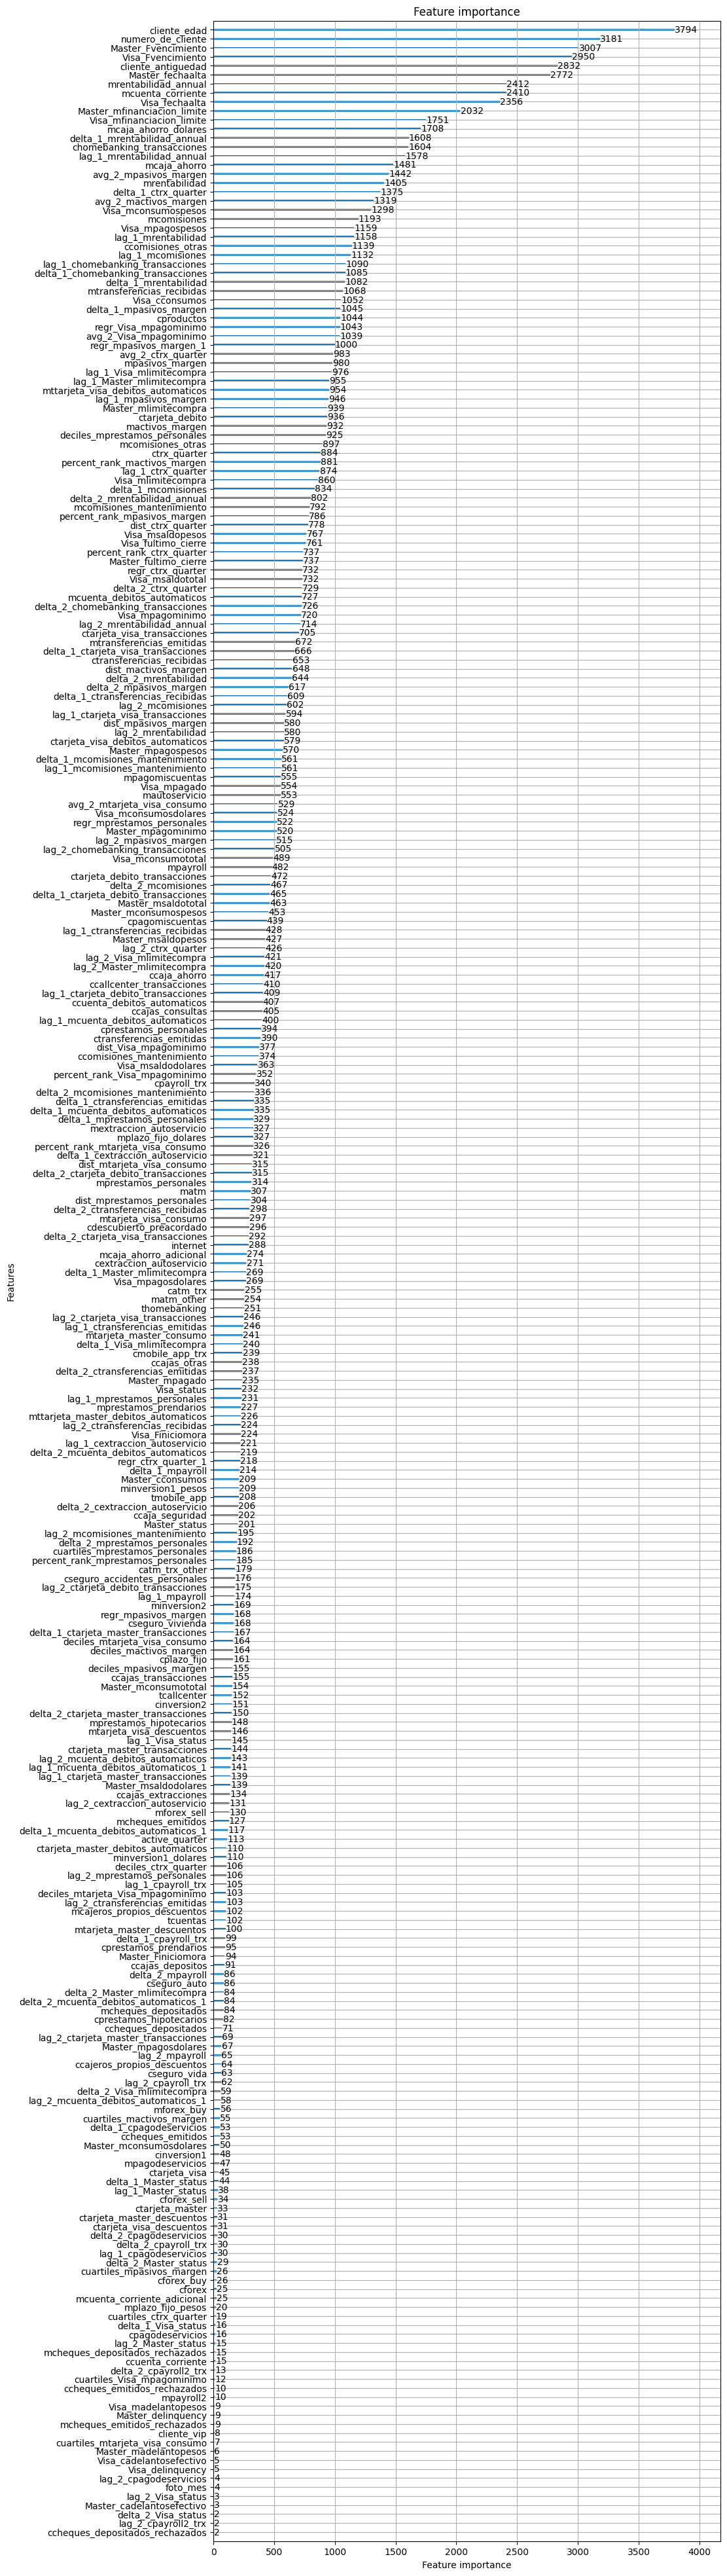

In [ ]:
lgb.plot_importance(model, figsize=(10, 50))
plt.show()


In [ ]:
mes_train_bis = [202101, 202102, 202103, 202104]
train_data_bis = data[data['foto_mes'].isin(mes_train_bis)]
X_train_bis = train_data_bis.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)

y_train_binaria1_bis = train_data_bis['clase_binaria1']
y_train_binaria2_bis = train_data_bis['clase_binaria2']
w_train_bis = train_data_bis['clase_peso']

In [ ]:
best_iter = study.best_trial.user_attrs["best_iter"]
print(f"Mejor cantidad de árboles para el mejor model {best_iter}")
params = {
        'objective': 'binary',
        'metric': 'custom',
        'boosting_type': 'gbdt',
        'first_metric_only': True,
        'boost_from_average': True,
        'feature_pre_filter': False,
        'max_bin': 31,
        'num_leaves': study.best_trial.params['num_leaves'], #num_leaves
        'learning_rate': study.best_trial.params['learning_rate'],#learning_rate,
        'min_data_in_leaf': study.best_trial.params['min_data_in_leaf'],#min_data_in_leaf,
        'feature_fraction': study.best_trial.params['feature_fraction'], #feature_fraction,
        'bagging_fraction': study.best_trial.params['bagging_fraction'], #bagging_fraction,
        'bagging_freq': study.best_trial.params['bagging_freq'], #bagging_freq,
        'lambda_l1': study.best_trial.params['lambda_l1'], #lambda_l1,
        'lambda_l2': study.best_trial.params['lambda_l2'], #lambda_l2,
        'min_gain_to_split': study.best_trial.params['min_gain_to_split'], #min_gain_to_split,
        'max_depth': study.best_trial.params['max_depth'], #max_depth,
        'seed': semillas[0],
        'verbose': -1
}

train_data = lgb.Dataset(X_train_bis,
                          label=y_train_binaria2_bis,
                          weight=w_train_bis)

model2 = lgb.train(params,
                  train_data,
                  num_boost_round=best_iter)

Mejor cantidad de árboles para el mejor model 1568


In [ ]:
 model2.save_model(modelos_path + 'lgb_20251011_4month_trainning.txt')

In [ ]:
junio_data = data[data['foto_mes'] == 202106]
X_test_junio = junio_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_pred_lgm_junio = model2.predict(X_test_junio)

In [ ]:
y_pred_lgm_junio_binario = np.where(y_pred_lgm_junio >= 0.0187, 1, 0)
print ('continua: ', np.sum(y_pred_lgm_junio_binario == 0))
print ('baja +2:' , np.sum(y_pred_lgm_junio_binario == 1))

continua:  154555
baja +2: 9758


In [ ]:
df_resultado = pd.DataFrame({
    'numero_de_cliente': junio_data['numero_de_cliente'],
    'Predicted': y_pred_lgm_junio_binario
})

print(df_resultado.head())

        numero_de_cliente  Predicted
178176          265131164          0
178177          280310576          0
178178          579788841          0
178179          502223400          0
178180         1194045186          0


In [ ]:
df_resultado.to_csv(dataset_path + 'resultado20251010_2.csv', index = False)